# Unshuffling Experiments

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from fastai.vision import *
import torch
import torchvision.transforms

In [4]:
torch.cuda.set_device(1)

In [5]:
from PixelShuffle import *

In [6]:
class SoftPermutation(torch.nn.Module):
    """Permutes images"""
    def __init__(self, n, init_method, **kwargs):
        super(SoftPermutation, self).__init__()
        self.n = n
        self.permMatrix = torch.nn.Linear(n, n)
        if init_method.lower() == 'identity':
            self.permMatrix.weight.data = torch.eye(n)
        elif init_method.lower() == 'solution':
            self.permMatrix.weight.data = kwargs['data'].transpose(0,1)
        else:
            raise ValueError(f"Init method unrecognized: {init_method}")
    
    def forward(self, x):
        """Performs forward on normal NxCxHxW image tensors"""
        shape = x.shape
        x = torch.reshape(x, (shape[0], shape[1], self.n))
        x = self.permMatrix(x)
        x = torch.reshape(x, shape)
        return x
    
class StackedUnshuffler(torch.nn.Module):
    def __init__(self, n, learnedModel, init_method, **kwargs):
        super(StackedUnshuffler, self).__init__()
        self.permutation = SoftPermutation(n, init_method, **kwargs)
        self.learnedModel = learnedModel
    
    def forward(self, x):
        x = self.permutation(x)
        x = self.learnedModel(x)
        return x
    
    def freeze_model(self):
        c = 0
        for p in self.learnedModel.parameters():
            c += 1
            p.requires_grad = False
        print(f"Froze {c} parameters")

Visualizing the solution permutation matrix

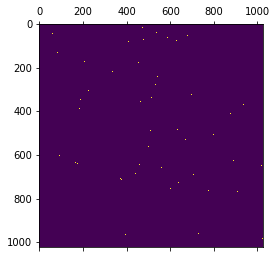

In [7]:
data, cifarShuffle = get_data_with_tfm(32, 128)
plt.matshow(cifarShuffle.createUnPermuteData())

## Load learned model

In order to first carry out experiments we want a few things.
* A trained model (model.learnedModel)
* A layer that can unpermute shuffled images (model.permutation)

Right now, the _model.permutation_ layer is just a linear layer that shifts around the flattened image.

Now we can begin Experiment 0: learning the model.permutation layer, given a trained model.

## Experiment 0:

Solution validation. To make sure that we have a layer that can unpermute the images, we test out version of the solution weight matrix for the linear layer.

In [8]:
learnedModel = models.wrn_22()
learnedModel.load_state_dict(torch.load('wrn22_pyramid_cycle'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## [0] Testing the solution data

cifarShuffle.createUnPermuteData()

In [9]:
experiment_arch = StackedUnshuffler(32*32, learnedModel, 'solution', data=cifarShuffle.createUnPermuteData())

In [10]:
experiment_learner = Learner(data, experiment_arch, metrics=[accuracy])
# Create layer groups that we can use to freeze the model
experiment_learner.split(lambda m:(m.learnedModel,))
experiment_learner.freeze_to(2)
experiment_learner.summary()

StackedUnshuffler
Layer (type)         Output Shape         Param #    Trainable 
Linear               [3, 1024]            1,049,600  False     
______________________________________________________________________
Conv2d               [16, 32, 32]         432        False     
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
Conv2d               [96, 32, 32]         13,824     False     
______________________________________________________________________
BatchNorm2d          [96, 32, 32]         192        True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [96, 32, 32]         82,944     False     
____________________________________________

In [11]:
preds, y, loss = experiment_learner.get_preds(with_loss=True)

In [12]:
accuracy(preds, y)

tensor(0.9067)

For comparison: here are WRN22's performances

| Dataset | Accuracy |
|---------|---------------------------|
| Unshuffled | 0.9075 |
| Shuffled | 0.9073 |

Accuracy w/ solution on shuffled: 0.9050

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


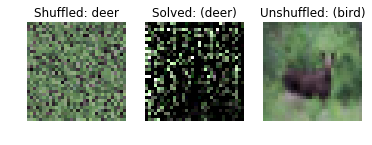

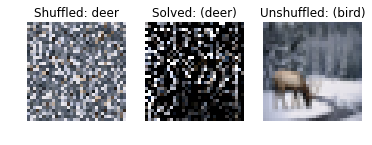

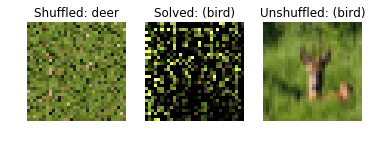

In [41]:
cifarUnshuffledData = get_data(32, 128, with_shuffle=False)
def visualizeIdxRange(givenRange, experiment_learner):
    def quick_pred(image, layer=None):
        model_input = image.data.unsqueeze(0).cuda()
        if layer is None:
            pred = model(model_input)
            return pred.argmax()
        elif layer.lower() == "perm":
            model = experiment_learner.model.permutation
            pred = model(model_input)
            return pred
        elif layer.lower() == "learned":
            model = experiment_learner.model.learnedModel
            pred = model(model_input)
            return pred.argmax()
        raise Exception("layer param wrong")

    for i in givenRange:
        unshuffledImg, unshuffledLbl = cifarUnshuffledData.train_ds[i]
        shuffledImg, shuffledLbl = data.train_ds[i]

        fig, axes = plt.subplots(1,3)
        top = axes
        shuffledImg.show(top[0])
        unshuffledImg.show(top[2])

        solvedImgData = quick_pred(shuffledImg, layer='perm').squeeze().detach().cpu()
        print(solvedImgData.shape)
        solvedImg = Image(solvedImgData)
        solvedImg.show(top[1])

        predictedLbl = data.train_ds.y.reconstruct(quick_pred(solvedImg, layer='learned'))
        predictedLbl2 = cifarUnshuffledData.train_ds.y.reconstruct(quick_pred(unshuffledImg, layer="learned"))
        top[0].set_title(f"Shuffled: {shuffledLbl}")
        top[1].set_title(f"Solved: ({predictedLbl})")
        top[2].set_title(f"Unshuffled: ({predictedLbl2})")

visualizeIdxRange(range(20000,20003), experiment_learner)

In [15]:
experiment_learner.layer_groups[0].requires_grad = True

In [16]:
experiment_learner.fit(30, callbacks=[BnFreeze(experiment_learner)])

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.008564,0.430348,0.903500,00:41
0,0.008564,0.430348,0.903500,00:41
1,0.004495,0.458022,0.906900,00:42
1,0.004495,0.458022,0.906900,00:42
2,0.004992,0.492068,0.904900,00:42
2,0.004992,0.492068,0.904900,00:42
3,0.004078,0.522027,0.902500,00:42
3,0.004078,0.522027,0.902500,00:42
4,0.004859,0.540729,0.903600,00:42


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=RGB size=32x32 at 0x7F17974CDE48>>
Traceback (most recent call last):
  File "/home/ngundotra/.conda/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 600, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


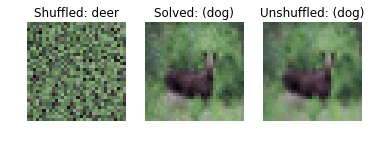

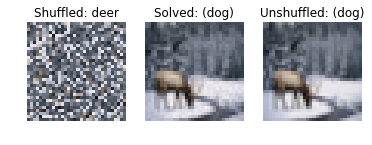

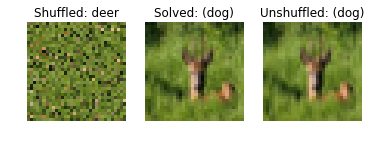

In [17]:
visualizeIdxRange(range(20000,20003))

## [0] Results: 

Even when we freeze the trained model's layers, freeze its batchnorm statistics, and only train the permutation layer, we somehow still a slight improvement. Which is probably just the _model.permutation_ layer learning how to manipulate the frozen trained model.

# Experiment 1:

Training the _model.permutation_ layer from scratch (aka not from the solution), given a trained model.

In [70]:
random_weight_init = cifarShuffle.createUnPermuteData()
random_weight_init = torch.nn.init.kaiming_uniform_(random_weight_init, np.sqrt(5))

In [27]:
experiment_arch = StackedUnshuffler(32*32, learnedModel, 'solution', data=random_weight_init)
experiment_learner = Learner(data, experiment_arch, metrics=[accuracy])
# Create layer groups that we can use to freeze the model
experiment_learner.split(lambda m:(m.learnedModel,))
experiment_learner.freeze_to(2)

Allow the permutation layer to learn.

In [28]:
experiment_learner.layer_groups[0].requires_grad = True

In [29]:
experiment_learner.fit(30)

epoch,train_loss,valid_loss,accuracy,time
0,1.986012,1.921266,0.293300,00:42
1,1.775053,1.752066,0.353100,00:42
2,1.689058,1.685506,0.393800,00:42
3,1.628906,1.629411,0.416800,00:41
4,1.597624,1.592561,0.425200,00:42
5,1.554024,1.593081,0.423400,00:42
6,1.534132,1.575534,0.431900,00:42
7,1.528426,1.563714,0.437200,00:42
8,1.529840,1.545879,0.439700,00:44
9,1.500362,1.568620,0.439200,00:44


# Experiment 2: Penalizing Linear Shuffle Layer

Penalize the layer's weights to 1 by adding it as a regularizer

In [42]:
random_weight_init = cifarShuffle.createUnPermuteData()
random_weight_init = torch.nn.init.kaiming_uniform_(random_weight_init, np.sqrt(5))

experiment_arch = StackedUnshuffler(32*32, learnedModel, 'solution', data=random_weight_init)
experiment_learner = Learner(data, experiment_arch, metrics=[accuracy])
# Create layer groups that we can use to freeze the model
experiment_learner.split(lambda m:(m.learnedModel,))
experiment_learner.freeze_to(2)

# Allow permutation layer to learn
experiment_learner.layer_groups[0].requires_grad = True

In [48]:
def regularizeWeightRows(weight):
    loss = 0
    for row in range(len(weight)):
        loss += torch.norm(weight[row])
    return loss

normalLoss = experiment_learner.loss_func
regularizedLoss = lambda *args, **kwargs: normalLoss(*args, **kwargs) + regularizeWeightRows(random_weight_init)

In [44]:
experiment_learner.loss_func = regularizedLoss

In [ ]:
experiment_learner.fit(30)

epoch,train_loss,valid_loss,accuracy,time
0,592.736206,592.730530,0.394000,00:41
1,592.666931,592.781494,0.376800,00:41
2,592.639038,592.706604,0.414200,00:41
3,592.621765,592.658691,0.427400,00:41
4,592.584045,592.759033,0.403100,00:41
5,592.581482,592.696228,0.419000,00:42
6,592.569885,592.613464,0.445400,00:42
7,592.576050,592.776306,0.391300,00:41
8,592.559082,592.731018,0.407800,00:42
9,592.551636,592.716248,0.415200,00:42


# Experiment 3: Forced regularization

Now let's see what happens when we force the weight layers to be normalize on each forward step.

In [102]:
random_weight_init = cifarShuffle.createUnPermuteData()
# random_weight_init = torch.nn.init.kaiming_uniform_(random_weight_init, np.sqrt(5))
torch.nn.init.normal_(random_weight_init, std=1.0/32/np.sqrt(2))
experiment_arch = StackedUnshuffler(32*32, learnedModel, 'solution', data=random_weight_init)
experiment_learner = Learner(data, experiment_arch, metrics=[accuracy])

In [103]:
matrix = random_weight_init.numpy().T @ random_weight_init.numpy()

In [104]:
np.sqrt(np.sum((matrix - np.eye(1024))**2))

22.63384902073744

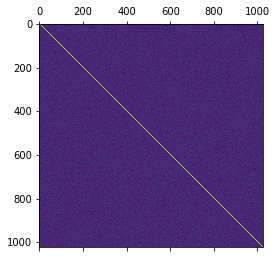

In [105]:
plt.matshow(random_weight_init.numpy().T @ random_weight_init.numpy())

In [106]:
class CrossCorrelator(torch.nn.Module):
    def __init__(self, k=3):
        super(CrossCorrelator, self).__init__()
        self.layer = torch.nn.Conv2d(3, 1, kernel_size=k, stride=1, padding_mode='zeros')
        
        filters = []
        for i in [0, 1, 2, 3, 5, 6, 7, 8]:
            curr_filter = np.zeros(9)
            curr_filter[i] = 1
            curr_filter
            filters.append()
        
        random_conv_wt = torch.zeros((1,3,3,8)).cuda()
        torch.nn.init.normal_(random_conv_wt)
        self.layer.weight.data = random_conv_wt
        self.layer.bias.data = torch.zeros_like(self.layer.bias.data).cuda()
        
    def forward(self, image):
        return torch.sum(torch.flatten(self.layer(image)))

In [107]:
def fitWithClamped(learner, epochs, alpha=1, beta=1, visualize=True):
    model = learner.model
    pbar = master_bar(range(epochs))
    optim = torch.optim.Adadelta(model.parameters())
    # Initialize Pixel Cross Correlator
    cross_correlator = CrossCorrelator(k=3)
    cross_correlator.requires_grad = False
    # Set model up for training
    for p in model.parameters():
        p.requires_grad = True
    
    for epoch in pbar:
        for xb, yb in progress_bar(learner.data.train_dl, parent=pbar):
            permMatrix = model.permutation.permMatrix.weight
            
            unshuffled_layer = model.permutation(xb)
            preds = model.learnedModel(unshuffled_layer)
            loss = learner.loss_func(preds, yb)
            ortho_loss = orthogonality(permMatrix)
#             cross_corr_loss = cross_correlator(unshuffled_layer) / (len(xb))
            real_loss = loss + alpha * ortho_loss 
            optim.zero_grad()
            print(f"Loss: {loss}, orthogonality: {ortho_loss}, cross correlation: {cross_corr_loss}")
            real_loss.backward()
            optim.step()
#             permMatrix.clamp_(min=0)
#             model.permutation.permMatrix.weight.data = torch.nn.functional.normalize(permMatrix, p=1, dim=1)
        visualizeIdxRange(range(2000, 2003), experiment_learner)
            
def orthogonality(matrix):
    """x^Tx - I"""
    prod = torch.mm(matrix.transpose(1,0), matrix)
    identity = torch.eye(matrix.shape[0])
    off_diagonal = prod - identity.cuda()
    return torch.norm(off_diagonal)

In [108]:
orthogonality(experiment_learner.model.permutation.permMatrix.weight.cuda())

tensor(22.6338, device='cuda:1', grad_fn=<NormBackward0>)

In [109]:
fitWithClamped(experiment_learner, 2)

Loss: 5.516633033752441, orthogonality: 22.633848190307617, cross correlation: 0.7352495193481445
Loss: 2.4466893672943115, orthogonality: 23.830690383911133, cross correlation: 490.18072509765625
Loss: 2.3125362396240234, orthogonality: 33.01033020019531, cross correlation: 1122.391357421875
Loss: 2.2520039081573486, orthogonality: 57.322242736816406, cross correlation: 2515.429931640625
Loss: 2.234102249145508, orthogonality: 106.23772430419922, cross correlation: 3030.39306640625
Loss: 2.2595815658569336, orthogonality: 163.9416961669922, cross correlation: 4359.4091796875
Loss: 2.2202765941619873, orthogonality: 238.27220153808594, cross correlation: 4285.3896484375
Loss: 2.303267478942871, orthogonality: 305.1330871582031, cross correlation: 4211.27294921875
Loss: 2.2268881797790527, orthogonality: 370.2815246582031, cross correlation: 5261.23291015625
Loss: 2.246173620223999, orthogonality: 452.40618896484375, cross correlation: 5923.0546875
Loss: 2.2306787967681885, orthogonalit

Loss: 2.1136093139648438, orthogonality: 10652.6630859375, cross correlation: 25966.494140625
Loss: 1.987121343612671, orthogonality: 10667.6591796875, cross correlation: 30199.583984375
Loss: 2.0606276988983154, orthogonality: 10789.90625, cross correlation: 24607.0390625
Loss: 2.0483453273773193, orthogonality: 10780.5693359375, cross correlation: 30250.962890625
Loss: 1.9853074550628662, orthogonality: 10905.076171875, cross correlation: 44128.6953125
Loss: 2.026031970977783, orthogonality: 11240.72265625, cross correlation: 19538.4140625
Loss: 2.0831971168518066, orthogonality: 11116.9931640625, cross correlation: 35854.609375
Loss: 2.053701639175415, orthogonality: 11316.076171875, cross correlation: 41348.171875
Loss: 2.0767312049865723, orthogonality: 11577.439453125, cross correlation: 38795.359375
Loss: 1.960900902748108, orthogonality: 11828.05859375, cross correlation: 39577.953125
Loss: 2.033987522125244, orthogonality: 12061.8564453125, cross correlation: 31827.1015625
Los

KeyboardInterrupt: 

Best so far: 

- 2.3 -> 2.17 (no constraints)
- 2.3 -> 2.00 (ortho loss)

In [64]:
current_weight_matrix = experiment_learner.model.permutation.permMatrix.weight.data.cpu().numpy()

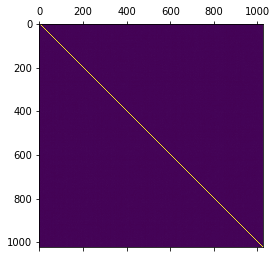

In [66]:
plt.matshow(current_weight_matrix.T @ current_weight_matrix)

In [36]:
preds, y, loss = experiment_learner.get_preds(with_loss=True)

In [37]:
accuracy(preds, y)

tensor(0.4238)

# Next Steps?

- Correlate nearby pixels, each row of the permMatrix is sampling all the pixels
- - Each row should focus on "nearby" pixels, that have similar correlations in "unshuffled" regions (in batch or dataset)
- - Want higher correlation (pairwise) of k x k regions in unshuffled (k << )



- Minimize off-diagonal elements of $X^TX$ (if we remove non-negativity restraint & change $\infty$-regularization to L2)

# Experiment Results:

Unshufflers were trying to unshuffled the dataset, given a frozen trained model (WRN-22)

| Method | Training Process | Accuracy |
| ------ | -------- |
| Unshuffler | 30 epochs | 46.48|
| Unshuffler, L2 reg | 30 epochs | ? |
| Unshuffler, $X^TX - I$ loss | 2 epochs | 43.28 |


In [112]:
preds, y, loss = experiment_learner.get_preds(with_loss=True)

In [113]:
accuracy(preds, y)

tensor(0.8474)

In [114]:
experiment_learner.model.learnedModel

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): BasicBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1):

In [115]:
unshuffledData = get_data(32, 128, with_shuffle=False)
unshuffledModel = Learner(unshuffledData, experiment_learner.model.learnedModel)

In [116]:
ps, ys = unshuffledModel.get_preds()

In [117]:
accuracy(ps, ys)

tensor(0.8440)